# Arm Position Error Correction

In this notebook, our goal is to correct real world error in the theoretical model that transforms servo position values $(s_1, s_2)$ to coordinates $(x, y)$ for a [SCARA](https://en.wikipedia.org/wiki/SCARA) on a chessboard plane.

## INSERT Diagram of arm

Given the variables in the above diagram we have two equations, one to calculate the $x$, and one for the $y$ for any $s_1, s_2$ combo (given that $0<s_1<1023$ and $0<s_2<1023$ – this range is due to the 10 bit accuracy of the [Dynamixel AX-12A](http://support.robotis.com/en/product/dynamixel/ax_series/dxl_ax_actuator.htm#Actuator_Address_1E) servo).

$$f_x(s_1, s_2) = x_{offset} + \cos(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi_{s_1} + \theta'_{s_1})\cdot l_1 + \cos((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi_{s_1} + \theta'_{s_1}) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi_{s_2} + \theta'_{s_2})) \cdot l_2 \\[10pt]$$
$$f_y(s_1, s_2) = y_{offset} + \sin(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi_{s_1} + \theta'_{s_1})\cdot l_1 + \sin((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi_{s_1} + \theta'_{s_1}) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi_{s_2} + \theta'_{s_2})) \cdot l_2$$

However, both $f_x$ and $f_y$ are assuming ideal conditions. In reality there is error introduced by inaccuracies in measurements, and unexpected real world effects on the system.

## INSERT Image showing error

In order to achieve better accuracy in reality we need to better understand this error component and account for it.

$$f'_x(s_1, s_2) = f_x(s_1, s_2) + \epsilon_x(s_1, s_2)$$
$$f'_y(s_1, s_2) = f_y(s_1, s_2) + \epsilon_y(s_1, s_2)$$

$f'_x$ and $f'_y$ represent the actual real world $x, y$ given any $s_1, s_2$, where $\epsilon_x$ and $\epsilon_y$ is the respective error. Our goal is to, as accurately as possible, model $\epsilon$.

In order to model $\epsilon$ we first need to collect a sample of data points. To do this I manually moved the arm to to 81 points and recorded the real $x, y$ and the respective $s_1, s_2$. Let's begin there.

In [61]:
import numpy as np
import pandas as pd

data = pd.read_csv('arm_error.csv')

In [62]:
data.head()

,s1,s2,x,y
0,945,672,18.00,18.00
1,756,396,9.00,9.00
2,389,1023,0.25,17.75
3,1023,0,16.30,0.00


We need two new columns for $x$ and $y$ error. We can calculate this by first calulating the theoretical coordinate and then subtracting the observed coordinate.

Variable/symbols:
- `s1_gear_ratio` => $\phi_{s_1}$
- `s2_gear_ratio` => $\phi_{s_2}$
- `s1_rotation_offset` => $\theta'_{s_1}$
- `s2_rotation_offset` => $\theta'_{s_2}$
- `arm1_reach` => $l_1$
- `arm2_reach` => $l_2$
- `x_offset` => $x_{offset}$
- `y_offset` => $y_{offset}$

In [63]:
dynamixel_range = 300.0
s1_gear_ratio = 84.0 / 32.0
s2_gear_ratio = 76.0 / 32.0
s1_rotation_offset = np.pi/6.0
s2_rotation_offset = np.pi/4.0
arm1_reach = 15.25
arm2_reach = 13.75
x_offset = 20.00
y_offset = 0.0

def f(s1, s2):
    s1_rotation = ((1023.0-s1)/1023.0) * np.deg2rad(dynamixel_range / s1_gear_ratio) + s1_rotation_offset
    s2_rotation = ((1023.0-s2)/1023.0) * np.deg2rad(dynamixel_range / s2_gear_ratio) + s2_rotation_offset + s1_rotation
    x = x_offset + np.cos(s1_rotation) * arm1_reach + np.cos(s2_rotation) * arm2_reach
    y = y_offset + np.sin(s1_rotation) * arm1_reach + np.sin(s2_rotation) * arm2_reach
    return np.array([x, y]).T

theoretical_xy = f(data.values[:,0], data.values[:,1])

In [64]:
data.rename(columns = {'x': 'x_real', 'y': 'y_real'}, inplace=True)
data["x_theory"] = theoretical_xy[:,0]
data["y_theory"] = theoretical_xy[:,1]
data["x_error"] = data["x_real"] - data["x_theory"]
data["y_error"] = data["y_real"] - data["y_theory"]

In [65]:
data.head()

,s1,s2,x_real,y_real,x_theory,y_theory,x_error,y_error
0,945,672,18.00,18.00,23.613975,20.511281,-5.613975,-2.511281
1,756,396,9.00,9.00,13.925136,12.644725,-4.925136,-3.644725
2,389,1023,0.25,17.75,5.758943,22.701546,-5.508943,-4.951546
3,1023,0,16.30,0.00,20.397510,2.626765,-4.097510,-2.626765


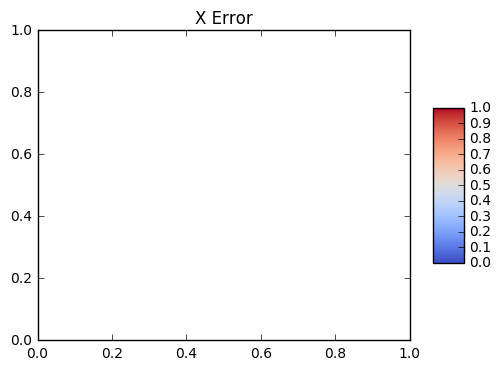

In [86]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
x_fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(data['s1'], data['s2'], data['x_error'], rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)

ax.xaxis.set_major_locator(LinearLocator(5))
ax.yaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

x_fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('X Error')
plt.show()

# y_fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(data['s1'], data['s2'], data['y_error'], rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# # ax.set_zlim(-1.01, 1.01)

# ax.xaxis.set_major_locator(LinearLocator(5))
# ax.yaxis.set_major_locator(LinearLocator(5))
# ax.zaxis.set_major_locator(LinearLocator(5))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# y_fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.title('Y Error')
# plt.show()


# ax.plot_trisurf(data['s1'], data['s2'], data['x_error'], linewidth=0.2)
# plt.show()